In [1]:
import numpy as np
from matplotlib import pyplot as plt
# import tempfile
# import os
# import shutil
import glob
import xarray as xr
import netCDF4

# import shapely
import pyart
from tint import Cell_tracks, animate
import pandas as pd
import datetime

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D   

from shapely.geometry import Polygon, Point, MultiPoint
from trackedcell_info import max_cell_area, ds_cell_1time, max_cell_edges, ds_celledges_1time

# import sys
import skimage.color
import skimage.filters
import skimage.io
import skimage.viewer
import skimage.measure
import skimage.color


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
from PIL import Image
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
import cv2
from scipy import ndimage
import argparse
# import imutils
import scipy as sp
from matplotlib import rcParams, cycler
# For the colorbar
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

In [3]:
def idx_win_cell(edge):
    # Given cell edges, return the idx point grid within them 
    cell_poly_grid = Polygon(edge)

    grid_x = np.meshgrid(np.arange(401), np.arange(401))[0].flatten()
    grid_y = np.meshgrid(np.arange(401), np.arange(401))[1].flatten()

    # -- Radar centers inside cell shape
    radar_shp = MultiPoint(tuple(np.vstack((grid_x, grid_y)).transpose()))
    XRAD = [] 
    YRAD = []
    for i in np.arange(len(grid_x)):
        if cell_poly_grid.contains(radar_shp[i]) == True:
            XRAD.append(np.asarray(radar_shp[i].coords[0])[0])
            YRAD.append(np.asarray(radar_shp[i].coords[0])[1])
    XRAD = np.asarray(XRAD, dtype='int')
    YRAD = np.asarray(YRAD, dtype='int')

    return XRAD,YRAD

In [4]:
class my_dictionary(dict):  
    # __init__ function 
    def __init__(self): 
        self = dict() 
    # Function to add key:value 
    def add(self, key, value): 
        self[key] = value 

In [5]:
# - Already gridded radar files
filenames = sorted(glob.glob('/home/jessica/tracer/KHGX20170713_*c_grid.nc'))
print(len(filenames))
grids = (pyart.io.read_grid(fn) for fn in filenames)
filenames

84


['/home/jessica/tracer/KHGX20170713_080047_V06_proc_grid.nc',
 '/home/jessica/tracer/KHGX20170713_080429_V06_proc_grid.nc',
 '/home/jessica/tracer/KHGX20170713_080826_V06_proc_grid.nc',
 '/home/jessica/tracer/KHGX20170713_081222_V06_proc_grid.nc',
 '/home/jessica/tracer/KHGX20170713_081619_V06_proc_grid.nc',
 '/home/jessica/tracer/KHGX20170713_082016_V06_proc_grid.nc',
 '/home/jessica/tracer/KHGX20170713_082358_V06_proc_grid.nc',
 '/home/jessica/tracer/KHGX20170713_082756_V06_proc_grid.nc',
 '/home/jessica/tracer/KHGX20170713_083207_V06_proc_grid.nc',
 '/home/jessica/tracer/KHGX20170713_083604_V06_proc_grid.nc',
 '/home/jessica/tracer/KHGX20170713_084031_V06_proc_grid.nc',
 '/home/jessica/tracer/KHGX20170713_084528_V06_proc_grid.nc',
 '/home/jessica/tracer/KHGX20170713_085010_V06_proc_grid.nc',
 '/home/jessica/tracer/KHGX20170713_085438_V06_proc_grid.nc',
 '/home/jessica/tracer/KHGX20170713_085905_V06_proc_grid.nc',
 '/home/jessica/tracer/KHGX20170713_090331_V06_proc_grid.nc',
 '/home/

In [6]:
# - TINT Track
tracks_obj = Cell_tracks()
tracks_obj.params
tracks_obj.params['GS_ALT'] = 3000
tracks_obj.params['FIELD_THRESH'] = 30
tracks_obj.get_tracks(grids)

Writing tracks for scan 0
Writing tracks for scan 1
Writing tracks for scan 2
Writing tracks for scan 3
Writing tracks for scan 4
Writing tracks for scan 5
Writing tracks for scan 6
Writing tracks for scan 7
Writing tracks for scan 8
Writing tracks for scan 9
Writing tracks for scan 10
Writing tracks for scan 11
Writing tracks for scan 12
Writing tracks for scan 13
Writing tracks for scan 14
Writing tracks for scan 15
Writing tracks for scan 16
Writing tracks for scan 17
Writing tracks for scan 18
Writing tracks for scan 19
Writing tracks for scan 20
Writing tracks for scan 21
Writing tracks for scan 22
Writing tracks for scan 23
Writing tracks for scan 24
Writing tracks for scan 25
Writing tracks for scan 26
Writing tracks for scan 27
Writing tracks for scan 28
Writing tracks for scan 29
Writing tracks for scan 30
Writing tracks for scan 31
Writing tracks for scan 32
Writing tracks for scan 33
Writing tracks for scan 34
Writing tracks for scan 35
Writing tracks for scan 36
Writing tra

In [7]:
# - Cells that were tracked for more frames
most_freq = tracks_obj.tracks.groupby(level='uid').size().sort_values(ascending=False)[:100].index

# - Cell centroid within the limits at least once
cid_idx1 = []
for freq in np.arange(len(most_freq)):
    cid = freq
    grids_cx = tracks_obj.tracks.xs(most_freq[cid], level='uid').grid_x.values
    grids_cy = tracks_obj.tracks.xs(most_freq[cid], level='uid').grid_y.values
    if (((grids_cx < 300.) & (grids_cy < 300.) & (grids_cx > 100.) & (grids_cy > 100.)).any() == True):
#         print(cid)
        cid_idx1.append(cid)
cid_idx1 = np.asarray(cid_idx1)

cid_idx2 = []
# - Cell survives for at least 2 scans
for n in np.arange(len(cid_idx1)):
    if len(tracks_obj.tracks.xs(most_freq[cid_idx1[n]], level='uid'))>2:
        cid_idx2.append(cid_idx1[n])

cid_idx3 = []
# - Cell is isolated
for n in np.arange(len(cid_idx2)):
    if (tracks_obj.tracks.xs(most_freq[cid_idx1[n]], level='uid').isolated.values).all() == True:
        cid_idx3.append(cid_idx2[n])
isolated=True

# - number of isolated cells
len(cid_idx3)

8

In [8]:
nb = 2 # number for the scan index
cid = cid_idx3[nb]
# Track scan number
nscans = tracks_obj.tracks.xs(most_freq[cid_idx3[nb]], level='uid').index.values

# - change x and y
cgridx = np.array(tracks_obj.tracks.xs(most_freq[cid], level='uid').grid_x.values,'i')
cgridy = np.array(tracks_obj.tracks.xs(most_freq[cid], level='uid').grid_y.values,'i')

# - number of scans 
len(nscans)

11

In [9]:
# - Backward propagation using 
# - Search for maximum reflectivity (above 10 dBZ)
nlevel=6
avg_area = np.ceil(np.mean(np.sqrt(tracks_obj.tracks.xs(most_freq[cid], level='uid').area.values))).astype(int)+2

cgridx0 = cgridx[0]
cgridy0 = cgridy[0]

back_cgridy = []
back_cgridx = []
peak_ref = []
# past_scan = 0
for past_i in np.arange(nscans[0]): 
    data = xr.open_dataset(filenames[nscans[0] - past_i])
    peak = np.nanmax(data['reflectivity'].values[0, nlevel, 
                                                 cgridy0-avg_area: cgridy0+avg_area,
                                                 cgridx0-avg_area:cgridx0+avg_area])
    if peak < 10:
        break   
    peak_ref.append(peak)
    past_scan = past_i
    back_cgridy.append(np.where(data['reflectivity'].values[0,nlevel,:,:] == peak_ref[past_i])[0][0])
    back_cgridx.append(np.where(data['reflectivity'].values[0,nlevel,:,:] == peak_ref[past_i])[1][0])
    
    # update center
    cgridx0 = back_cgridx[past_i]
    cgridy0 = back_cgridy[past_i]
    del(data)

# - Combining idx for the bw prop and the one done by tint
new_nscans = np.zeros(len(nscans)+past_scan)
new_cgridy, new_cgridx = np.zeros(len(nscans)+past_scan), np.zeros(len(nscans)+past_scan)
for idx,scan in zip(np.arange(past_scan+1), np.arange(past_scan,-1,-1)):
    new_nscans[idx] = nscans[0]-scan
    new_cgridy[scan] = back_cgridy[idx]
    new_cgridx[scan] = back_cgridx[idx]
new_nscans[past_scan:] = nscans
new_nscans = new_nscans.astype(int)
new_cgridy[past_scan:] = cgridy
new_cgridx[past_scan:] = cgridx
new_cgridx = new_cgridx.astype(int)
new_cgridy = new_cgridy.astype(int)

# - All the data for the cell
# - -past_scan to include the cell info before tint track
if back_cgridx:
    total_data = xr.open_dataset(filenames[nscans[0]-past_scan])
    for i in np.arange(past_scan-1,0,-1):
        data = xr.open_dataset(filenames[nscans[0]-i])
        total_data = xr.combine_by_coords([total_data, data])
        del(data)
    dict_cell = my_dictionary() 
    dict_keys = ['edges'+str(x) for x in range(len(new_nscans) + 1)]

    for i in np.arange(len(nscans)):
        data = xr.open_dataset(filenames[nscans[i]])
        total_data = xr.combine_by_coords([total_data, data])
        del(data)
else:
    total_data = xr.open_dataset(filenames[nscans[0]])
    for i in np.arange(1,len(nscans)):
        data = xr.open_dataset(filenames[nscans[i]])
        total_data = xr.combine_by_coords([total_data, data])
        del(data)
    dict_cell = my_dictionary() 
    dict_keys = ['edges'+str(x) for x in range(len(nscans) + 1)]
    new_cgridx = cgridx
    new_cgridy = cgridy
    new_nscans = nscans

In [10]:
# - Getting cell edges - 1st approach - skimage
nlevel = 6
# ntime = 1
for ntime in np.arange(len(total_data.time.values)):
    blobs = total_data['reflectivity'].values[ntime,nlevel,:,:].copy()
    blobs = np.nan_to_num(blobs, 0)
    thres = 5
    blobs[np.where(blobs < thres)[0],np.where(blobs < thres)[1]] = 0
    blobs[np.where(blobs >= thres)[0],np.where(blobs >= thres)[1]] = 2
    # Perform CCA on the mask
    labeled = skimage.measure.label(blobs, connectivity=2, return_num=True)

    # labeled[cgridx,cgridy]  
    trk = labeled[0][new_cgridy[ntime],new_cgridx[ntime]]

    for i in np.arange(np.shape(skimage.measure.regionprops(labeled[0]))[0]):
        if (skimage.measure.regionprops(labeled[0])[i].label == trk):
            trk_pop = i
            print(i)

    shape = skimage.measure.regionprops(labeled[0])[trk_pop].coords

    edge = []
    for i in np.arange(np.shape(skimage.measure.find_contours(blobs, level=1))[0]):
        verts = skimage.measure.find_contours(blobs, level=1)[i]
        edge.append(np.shape(np.where(skimage.measure.points_in_poly(shape, verts)==True)[0])[0])

    trk_per = np.where(np.array(edge) == np.array(edge).max())[0][0]

    edges = skimage.measure.find_contours(blobs, level=1)[trk_per]
    edges = np.round(edges, 0)+0.5
    edges = edges.astype('int') #### fix 
    
#     dict_cell.add(dict_keys[ntime], edges)
    radar = pyart.io.read_grid(filenames[new_nscans[ntime]])
    edge_lon = radar.get_point_longitude_latitude(level = 0, edges = 'True')[0][edges[:,0], edges[:,1]]
    edge_lat = radar.get_point_longitude_latitude(level = 0, edges = 'True')[1][edges[:,0], edges[:,1]]
    time_center = time_center = total_data.time.values[ntime]
        
    XRAD,YRAD = idx_win_cell(edges)
    center_lon = radar.get_point_longitude_latitude(level = 0, edges = 'True')[0][XRAD,YRAD]
    center_lat = radar.get_point_longitude_latitude(level = 0, edges = 'True')[1][XRAD,YRAD]
    ref = total_data['reflectivity'][ntime,:,XRAD,YRAD].values
    zdr = total_data['differential_reflectivity'][ntime,:,XRAD,YRAD].values
    kdp = total_data['KDP_CSU'][ntime,:,XRAD,YRAD].values
#     rhohv = total_data['cross_correlation_ratio'][ntime,:,XRAD,YRAD].values
#     phidp = total_data['differential_phase'][ntime,:,XRAD,YRAD].values
    d0 = total_data['D0'][ntime,:,XRAD,YRAD].values
    nw = total_data['NW'][ntime,:,XRAD,YRAD].values
    mu = total_data['MU'][ntime,:,XRAD,YRAD].values
    mw = total_data['MW'][ntime,:,XRAD,YRAD].values
    mi = total_data['MI'][ntime,:,XRAD,YRAD].values

    dict_cell.add(dict_keys[ntime], [edges, edge_lon, edge_lat, time_center,
                                     center_lon, center_lat,
                                     ref, zdr, kdp, 
#                                      rhohv,
                                     d0, nw, mu, mw, mi])

46
49
47
47
53
52
59
62
56
55
50
57
59
60
57
56


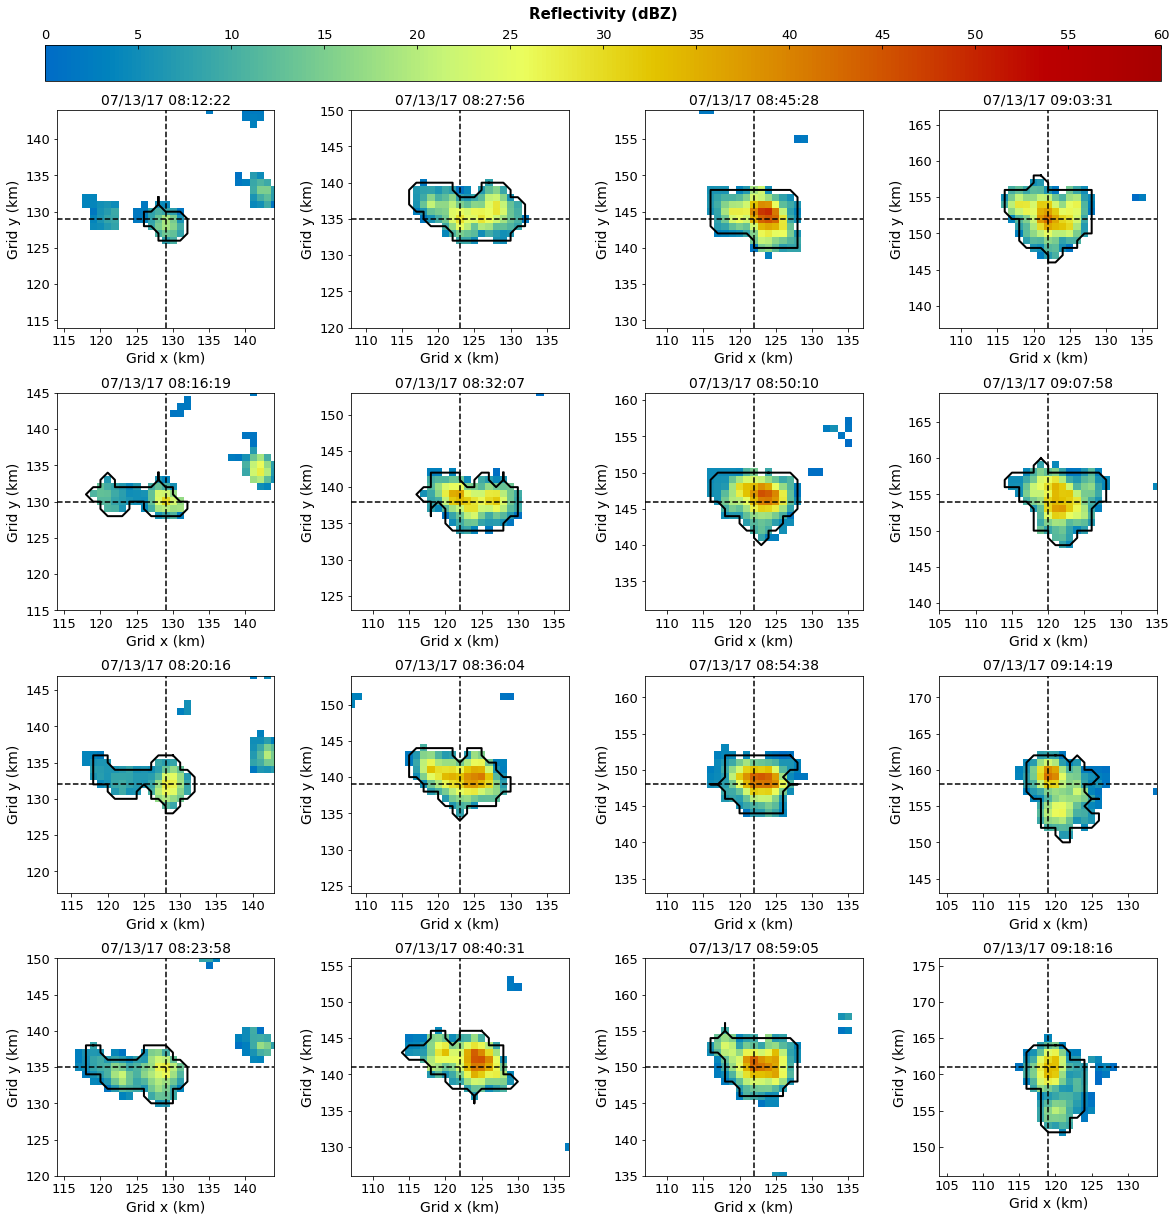

In [11]:
ncol = 4
nrow = int(np.ceil(len(new_nscans)/4))
##
k = 0
tti = datetime.datetime.utcfromtimestamp(total_data['time'].values[k].tolist()/1e9)
fig = plt.figure(figsize=[ncol*5,nrow*5])
for c in np.arange(ncol):
    for r in np.arange(nrow):
        ix = r*ncol + c
        ax = plt.subplot(nrow,ncol,ix+1)
        cs=plt.imshow(total_data['reflectivity'].values[k,6,:,:], origin = 'lower', 
                      cmap = 'pyart_HomeyerRainbow', vmin = 0, vmax = 60)
        plt.plot(dict_cell[dict_keys[k]][0][:,1],dict_cell[dict_keys[k]][0][:,0],
                 linewidth = 2, c = 'black')        
        zoom = 15
        plt.hlines(new_cgridy[k],new_cgridx[k] - zoom,new_cgridx[k] + zoom, color='black',linestyle='dashed')
        plt.vlines(new_cgridx[k],new_cgridy[k] - zoom,new_cgridy[k] + zoom, color='black',linestyle='dashed')
        plt.ylim(new_cgridy[k] - zoom, new_cgridy[k] + zoom)
        plt.ylabel('Grid y (km)',fontsize=14)
        plt.xlim(new_cgridx[k] - zoom, new_cgridx[k] + zoom)
        plt.xlabel('Grid x (km)',fontsize=14)
        plt.yticks(fontsize = 13)
        plt.xticks(fontsize = 13)
        tt = datetime.datetime.utcfromtimestamp(total_data['time'].values[k].tolist()/1e9)
        plt.title(tt.strftime("%m/%d/%y %H:%M:%S"),fontsize = 14)
        k=k+1
        if k == len(new_nscans):
            break
            
# - Colorbar
cax = fig.add_axes([0.125, 0.89, 0.775, 0.025])
cbar = fig.colorbar(cs, cax = cax, ticks = np.arange(0,65,5), orientation = 'horizontal')
cbar.set_label('Reflectivity (dBZ)', size = 15, fontweight = 'bold', labelpad = 10)
cbar.ax.tick_params(labelsize=13)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
ax.tick_params(direction = 'in')
cbar.ax.tick_params(direction = 'in')

plt.subplots_adjust(top=0.87, bottom=0.13, left=0.13, right=0.9, hspace=0.3, wspace=0.3)

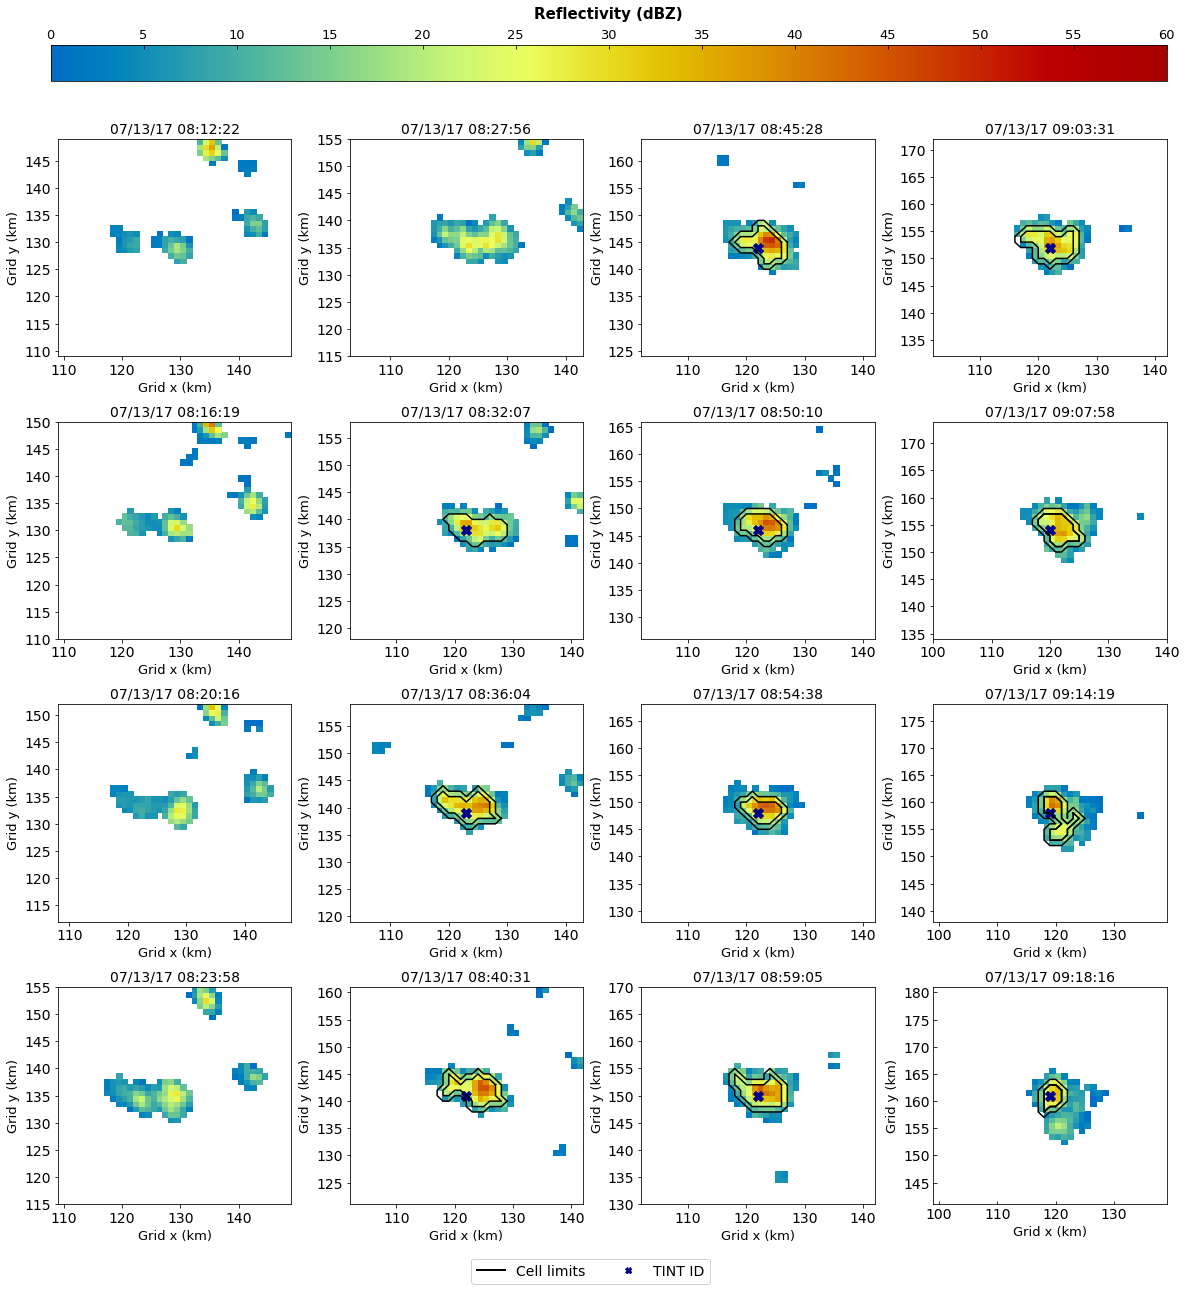

In [12]:
x = np.arange(-200,201)
y = np.arange(-200,201)
x = np.arange(0,401)
y = np.arange(0,401)
xx, yy = np.meshgrid(x,y)

#####1
zoom = 20
ncol = 4
nrow = int(np.ceil(len(new_nscans)/4))
##
nt = 0
tti = datetime.datetime.utcfromtimestamp(total_data['time'].values[nt].tolist()/1e9)
fig = plt.figure(figsize=[ncol*5,nrow*5])
for c in np.arange(ncol):
    for r in np.arange(nrow):
        ix = r*ncol + c
        ax = plt.subplot(nrow,ncol,ix+1)
        #
        # - Getting cell edges - 2nd approach - watershed
        ref = total_data['reflectivity'].values[nt,6,:,:].copy()
        norm = ((ref - np.nanmin(ref)) / (np.nanmax(ref) - np.nanmin(ref)))
        image = norm*255
        image[image<((np.nanpercentile(ref,70) - np.nanmin(ref)) / (np.nanmax(ref) - np.nanmin(ref)))*255]=0
        image[image>((np.nanpercentile(ref,70) - np.nanmin(ref)) / (np.nanmax(ref) - np.nanmin(ref)))*255]=255
        test=Image.fromarray(np.uint8(image))
        test.save("file.jpeg")
        image = cv2.imread("file.jpeg")
        shifted = cv2.pyrMeanShiftFiltering(src = image, sp = 15, sr = 100)
        gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
        thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
        D = ndimage.distance_transform_edt(thresh)

        localMax =  np.full((401, 401), False)
        localMax[np.array(tracks_obj.tracks.grid_y[new_nscans[nt]].values,'i'), np.array(tracks_obj.tracks.grid_x[new_nscans[nt]].values,'i')]=True
        markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
        labels = watershed(-D, markers, mask=thresh)
        #
        cs=plt.pcolormesh(xx, yy, ref, cmap = 'pyart_HomeyerRainbow', vmin = 0, vmax = 60, alpha=1)
        #
        plt.scatter(np.array(tracks_obj.tracks.grid_x[new_nscans[nt]].values,'i'), np.array(tracks_obj.tracks.grid_y[new_nscans[nt]].values,'i'), marker='X',color='darkblue',s=100)

        for k in np.arange(len(np.array(tracks_obj.tracks.grid_x[new_nscans[nt]].values,'i'))):
            trks = labels[np.array(tracks_obj.tracks.grid_y[new_nscans[nt]].values,'i')[k], np.array(tracks_obj.tracks.grid_x[new_nscans[nt]].values,'i')[k]]
            edge_mx = np.zeros_like(ref)
            edge_mx[np.where(labels==trks)[1], np.where(labels==trks)[0]] = 1
            edges = skimage.measure.find_contours(edge_mx, level=0)[0]
            plt.plot(edges[:,0], edges[:,1], color = 'black')
        #
        plt.ylim(new_cgridy[nt] - zoom, new_cgridy[nt] + zoom)
        plt.ylabel('Grid y (km)', fontsize=13)
        plt.xlim(new_cgridx[nt] - zoom, new_cgridx[nt] + zoom)
        plt.xlabel('Grid x (km)', fontsize=13)
        plt.yticks(fontsize = 14)
        plt.xticks(fontsize = 14)
        plt.title(total_data['time'].values[nt],fontsize = 5)
        tt = datetime.datetime.utcfromtimestamp(total_data['time'].values[nt].tolist()/1e9)
        plt.title(tt.strftime("%m/%d/%y %H:%M:%S"),fontsize = 14)
        nt=nt+1
        if nt == len(new_nscans):
            break

# - Colorbar
cax = fig.add_axes([0.125, 0.91, 0.775, 0.025])
cbar = fig.colorbar(cs, cax = cax, ticks = np.arange(0,65,5), orientation = 'horizontal')
cbar.set_label('Reflectivity (dBZ)', size = 15, fontweight = 'bold', labelpad = 10)
cbar.ax.tick_params(labelsize=13)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
ax.tick_params(direction = 'in')
cbar.ax.tick_params(direction = 'in')

legend_elements1 = [Line2D([0], [0], color='black',lw=2,linestyle = '-',marker = None,
                          markersize = 60, alpha=1,
                           label = 'Cell limits'),
                   Line2D([0], [0], lw=0,linestyle =None,marker = 'X',color='darkblue',
                          alpha=1,label = 'TINT ID')]

fig.legend(handles=legend_elements1, loc = 'lower center', ncol=2, fontsize = 14,
           bbox_to_anchor=(0.5, 0.07),framealpha = 0.9)
plt.subplots_adjust(top=0.87, bottom=0.13, left=0.13, right=0.9, hspace=0.3, wspace=0.25)